In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoModel

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

#set_seed(RANDOM_STATE)
#enable_full_determinism(RANDOM_STATE)


# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    scores = df.progress_apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["text_a"], r["text_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name=name)
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2024-01-07 16:14:11.584239: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("class-arxiv-dataset.csv", index_col=0)
df.sample(5)

,label,categories_a,text_a,categories_b,text_b
38532,0,"('math.NT',)","Redei reciprocity, governing fields, and negat...","('math.AP',)","First and second derivative H\""older estimates..."
38609,0,"('math.NT',)",On an identity for the projection operators of...,"('math.AC',)",On truncations of valuations. In this paper we...
7499,1,"('math.AP',)",Global bifurcation of capillary-gravity water ...,"('math.AP',)",Viscosity solutions of Eikonal equations on to...
49289,1,"('math.RT',)",Thomae's function on a Lie group. Let $\mathfr...,"('math.RT',)",Equivariant sheaves on loop spaces. Let $X$ be...
42750,0,"('math.OC',)",Reduction of SISO H-infinity Output Feedback C...,"('stat.ME',)",Stochastic partial differential equation based...


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 43572 eval: 5447 test: 5447


## Model definitions

In [4]:
# combine models into dict
eval_models = {
    "BERT+CLS+ANCH-ARX": SentenceTransformer('./bert+cls+retrain_anchor_arxiv'),
    "BERT+MP+ANCH-ARX": SentenceTransformer('./bert+mean-pooling+retrain_anchor_arxiv'),
    "BERT+CLS+CLASS-ARX": SentenceTransformer('./bert+cls+retrain_class_arxiv'),
    "BERT+MP+CLASS-ARX": SentenceTransformer('./bert+mean-pooling+retrain_class_arxiv'),
    "BERT+CLS+CLASS-ZBM": SentenceTransformer('./bert+cls+retrain_class_zbmath'),
    "BERT+MP+CLASS-ZBM": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath'),
    
    "SBERT+MP+ANCH-ARX": SentenceTransformer('./sbert+retrain_anchor_arxiv'),
    "SBERT+MP+CLASS-ARX": SentenceTransformer('./sbert+retrain_class_arxiv'),
    "SBERT+MP+CLASS-ZBM": SentenceTransformer('./sbert+retrain_class_zbmath'),
    
    "MathBERT+CLS+ANCH-ARX": SentenceTransformer('./mathbert+cls+retrain_anchor_arxiv'),
    "MathBERT+MP+ANCH-ARX": SentenceTransformer('./mathbert+mean-pooling+retrain_anchor_arxiv'),
    "MathBERT+CLS+CLASS-ARX": SentenceTransformer('./mathbert+cls+retrain_class_arxiv'),
    "MathBERT+MP+CLASS-ARX": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv'),
    "MathBERT+CLS+CLASS-ZBM": SentenceTransformer('./mathbert+cls+retrain_class_zbmath'),
    "MathBERT+MP+CLASS-ZBM": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath'),
    
    "SPECTER2+CLS+ANCH-ARX": SentenceTransformer('./specter2+cls+retrain_anchor_arxiv'),
    "SPECTER2+MP+ANCH-ARX": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv'),
    "SPECTER2+CLS+CLASS-ARX": SentenceTransformer('./specter2+cls+retrain_class_arxiv'),
    "SPECTER2+MP+CLASS-ARX": SentenceTransformer('./specter2+mp+retrain_class_arxiv'),
    "SPECTER2+CLS+CLASS-ZBM": SentenceTransformer('./specter2+cls+retrain_class_zbmath'),
    "SPECTER2+MP+CLASS-ZBM": SentenceTransformer('./specter2+mp+retrain_class_zbmath'),
    
    "SGPT+ANCH-ARX": SentenceTransformer('./gpt+retrain_anchor_arxiv'),
    "SGPT+CLASS-ARX": SentenceTransformer('./gpt+retrain_class_arxiv'),
    "SGPT+CLASS-ZBM": SentenceTransformer('./gpt+retrain_class_zbmath'),
    
    "BERT+MLM+CLS+ANCH-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_anchor_arxiv'),
    "BERT+MLM+MP+ANCH-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv'),
    "BERT+MLM+CLS+CLASS-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_class_arxiv'),
    "BERT+MLM+MP+CLASS-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv'),
    "BERT+MLM+CLS+CLASS-ZBM": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_class_zbmath'),
    "BERT+MLM+MP+CLASS-ZBM": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath'),
    
    "BERT+CLS+TSDAE+ANCH-ARX": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_anchor_arxiv'),
    "BERT+MP+TSDAE+ANCH-ARX": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_anchor_arxiv'),
    "BERT+CLS+TSDAE+CLASS-ARX": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "BERT+MP+TSDAE+CLASS-ARX": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "BERT+CLS+TSDAE+CLASS-ZBM": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
    "BERT+MP+TSDAE+CLASS-ZBM": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
}

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, batch_size=32, show_progress_bar=True)

In [6]:
%%time
spear_rancs = {}

with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        spear_rancs[n] = [m.evaluate(evaluator)]
        pb.update()
        
spear_ranc_df = pd.DataFrame(spear_rancs)

  0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

CPU times: user 1h 45min 33s, sys: 2min 53s, total: 1h 48min 27s
Wall time: 44min 22s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
spear_ranc_df

,BERT+CLS+ANCH-ARX,BERT+MP+ANCH-ARX,BERT+CLS+CLASS-ARX,BERT+MP+CLASS-ARX,BERT+CLS+CLASS-ZBM,BERT+MP+CLASS-ZBM,SBERT+MP+ANCH-ARX,SBERT+MP+CLASS-ARX,SBERT+MP+CLASS-ZBM,MathBERT+CLS+ANCH-ARX,MathBERT+MP+ANCH-ARX,MathBERT+CLS+CLASS-ARX,MathBERT+MP+CLASS-ARX,MathBERT+CLS+CLASS-ZBM,MathBERT+MP+CLASS-ZBM,SPECTER2+CLS+ANCH-ARX,SPECTER2+MP+ANCH-ARX,SPECTER2+CLS+CLASS-ARX,SPECTER2+MP+CLASS-ARX,SPECTER2+CLS+CLASS-ZBM,SPECTER2+MP+CLASS-ZBM,SGPT+ANCH-ARX,SGPT+CLASS-ARX,SGPT+CLASS-ZBM,BERT+MLM+CLS+ANCH-ARX,BERT+MLM+MP+ANCH-ARX,BERT+MLM+CLS+CLASS-ARX,BERT+MLM+MP+CLASS-ARX,BERT+MLM+CLS+CLASS-ZBM,BERT+MLM+MP+CLASS-ZBM,BERT+CLS+TSDAE+ANCH-ARX,BERT+MP+TSDAE+ANCH-ARX,BERT+CLS+TSDAE+CLASS-ARX,BERT+MP+TSDAE+CLASS-ARX,BERT+CLS+TSDAE+CLASS-ZBM,BERT+MP+TSDAE+CLASS-ZBM
0,0.386459,0.356994,0.761892,0.771056,0.344348,0.358264,0.101978,0.79973,0.410742,0.404196,0.42585,0.770821,0.780568,0.369488,0.399595,0.430597,0.427007,0.781055,0.782557,0.336594,0.38471,0.456996,0.722141,0.377287,0.476357,0.535472,0.802979,0.805574,0.403798,0.428703,0.429379,0.398978,0.766888,0.772503,0.360305,0.360723


In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        X_test_score["cos-sim ({})".format(n)] = st_similarity_scoring(X_test, m)
        pb.update()

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

CPU times: user 2h 59min 26s, sys: 1min 32s, total: 3h 58s
Wall time: 1h 1min 6s


## Results for test data

In [11]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cos-sim (BERT+CLS+ANCH-ARX),cos-sim (BERT+MP+ANCH-ARX),cos-sim (BERT+CLS+CLASS-ARX),cos-sim (BERT+MP+CLASS-ARX),cos-sim (BERT+CLS+CLASS-ZBM),cos-sim (BERT+MP+CLASS-ZBM),cos-sim (SBERT+MP+ANCH-ARX),cos-sim (SBERT+MP+CLASS-ARX),cos-sim (SBERT+MP+CLASS-ZBM),cos-sim (MathBERT+CLS+ANCH-ARX),cos-sim (MathBERT+MP+ANCH-ARX),cos-sim (MathBERT+CLS+CLASS-ARX),cos-sim (MathBERT+MP+CLASS-ARX),cos-sim (MathBERT+CLS+CLASS-ZBM),cos-sim (MathBERT+MP+CLASS-ZBM),cos-sim (SPECTER2+CLS+ANCH-ARX),cos-sim (SPECTER2+MP+ANCH-ARX),cos-sim (SPECTER2+CLS+CLASS-ARX),cos-sim (SPECTER2+MP+CLASS-ARX),cos-sim (SPECTER2+CLS+CLASS-ZBM),cos-sim (SPECTER2+MP+CLASS-ZBM),cos-sim (SGPT+ANCH-ARX),cos-sim (SGPT+CLASS-ARX),cos-sim (SGPT+CLASS-ZBM),cos-sim (BERT+MLM+CLS+ANCH-ARX),cos-sim (BERT+MLM+MP+ANCH-ARX),cos-sim (BERT+MLM+CLS+CLASS-ARX),cos-sim (BERT+MLM+MP+CLASS-ARX),cos-sim (BERT+MLM+CLS+CLASS-ZBM),cos-sim (BERT+MLM+MP+CLASS-ZBM),cos-sim (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (BERT+MP+TSDAE+ANCH-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (BERT+MP+TSDAE+CLASS-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (BERT+MP+TSDAE+CLASS-ZBM)
count,2766.0,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000
mean,1.0,0.256470,0.234815,0.785837,0.782105,0.419006,0.425780,0.173409,0.782517,0.389095,0.255081,0.257828,0.773006,0.773235,0.403397,0.428403,0.229972,0.236070,0.763531,0.765001,0.441511,0.396856,0.397396,0.724603,0.414705,0.278673,0.309436,0.808380,0.793282,0.406823,0.387010,0.311394,0.279807,0.761340,0.765141,0.387718,0.408199
std,0.0,0.239879,0.261288,0.272433,0.235095,0.236097,0.223664,0.732396,0.262012,0.232411,0.242604,0.233827,0.302913,0.283456,0.261665,0.256652,0.195524,0.203936,0.359409,0.347230,0.246055,0.248207,0.110203,0.222049,0.203780,0.216865,0.229814,0.260291,0.276639,0.248224,0.247860,0.210049,0.226740,0.327196,0.295902,0.247299,0.221122
min,1.0,-0.545516,-0.567965,-0.078735,-0.109813,-0.269717,-0.190105,-0.951680,-0.109060,-0.264290,-0.474833,-0.405558,-0.136073,-0.097196,-0.251127,-0.264380,-0.409283,-0.426336,-0.047311,-0.034635,-0.180724,-0.256416,0.039044,-0.150049,-0.235410,-0.326621,-0.379025,-0.057530,-0.058362,-0.221271,-0.189035,-0.376520,-0.422605,-0.102631,-0.096174,-0.311059,-0.307203
25%,1.0,0.087691,0.049221,0.668815,0.666341,0.239755,0.260140,-0.543751,0.649827,0.217412,0.085454,0.091683,0.619758,0.632045,0.203924,0.232942,0.089919,0.095634,0.567662,0.616801,0.250946,0.201937,0.321291,0.591757,0.272287,0.119538,0.139425,0.718060,0.701405,0.210543,0.191227,0.168811,0.115927,0.597937,0.631552,0.198985,0.245647
50%,1.0,0.260833,0.240569,0.918580,0.879166,0.417187,0.430812,0.224971,0.907161,0.380177,0.261939,0.271516,0.944213,0.920876,0.396663,0.425395,0.227339,0.236937,0.986424,0.977938,0.433142,0.382212,0.399068,0.792721,0.419331,0.278767,0.314269,0.945551,0.936178,0.396806,0.377112,0.321292,0.281133,0.954794,0.918170,0.378731,0.405511
75%,1.0,0.434257,0.432158,0.983671,0.963309,0.593500,0.601717,0.953037,0.978160,0.560087,0.435387,0.430946,0.992261,0.984445,0.607178,0.634748,0.366340,0.380720,0.997620,0.996510,0.634681,0.576342,0.471493,0.902170,0.566328,0.437525,0.474071,0.989522,0.986382,0.590897,0.571861,0.466332,0.447937,0.992223,0.985379,0.574357,0.567375
max,1.0,0.846632,0.884936,0.999372,0.998081,0.982703,0.973212,0.999826,0.999169,0.982946,0.872229,0.858483,0.999783,0.999374,0.977754,0.973570,0.803189,0.830950,0.999638,0.999770,0.984787,0.988655,0.796467,0.991304,0.939379,0.866347,0.900662,0.999396,0.998620,0.986181,0.978322,0.879452,0.869941,0.999589,0.999296,0.974820,0.961872


In [12]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cos-sim (BERT+CLS+ANCH-ARX),cos-sim (BERT+MP+ANCH-ARX),cos-sim (BERT+CLS+CLASS-ARX),cos-sim (BERT+MP+CLASS-ARX),cos-sim (BERT+CLS+CLASS-ZBM),cos-sim (BERT+MP+CLASS-ZBM),cos-sim (SBERT+MP+ANCH-ARX),cos-sim (SBERT+MP+CLASS-ARX),cos-sim (SBERT+MP+CLASS-ZBM),cos-sim (MathBERT+CLS+ANCH-ARX),cos-sim (MathBERT+MP+ANCH-ARX),cos-sim (MathBERT+CLS+CLASS-ARX),cos-sim (MathBERT+MP+CLASS-ARX),cos-sim (MathBERT+CLS+CLASS-ZBM),cos-sim (MathBERT+MP+CLASS-ZBM),cos-sim (SPECTER2+CLS+ANCH-ARX),cos-sim (SPECTER2+MP+ANCH-ARX),cos-sim (SPECTER2+CLS+CLASS-ARX),cos-sim (SPECTER2+MP+CLASS-ARX),cos-sim (SPECTER2+CLS+CLASS-ZBM),cos-sim (SPECTER2+MP+CLASS-ZBM),cos-sim (SGPT+ANCH-ARX),cos-sim (SGPT+CLASS-ARX),cos-sim (SGPT+CLASS-ZBM),cos-sim (BERT+MLM+CLS+ANCH-ARX),cos-sim (BERT+MLM+MP+ANCH-ARX),cos-sim (BERT+MLM+CLS+CLASS-ARX),cos-sim (BERT+MLM+MP+CLASS-ARX),cos-sim (BERT+MLM+CLS+CLASS-ZBM),cos-sim (BERT+MLM+MP+CLASS-ZBM),cos-sim (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (BERT+MP+TSDAE+ANCH-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (BERT+MP+TSDAE+CLASS-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (BERT+MP+TSDAE+CLASS-ZBM)
count,2681.0,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000
mean,0.0,0.061889,0.039512,0.140367,0.175521,0.258717,0.264845,0.022810,0.094952,0.201471,0.046747,0.045186,0.099076,0.106951,0.211865,0.219716,0.053919,0.054076,0.053360,0.055605,0.277884,0.211338,0.283139,0.224398,0.255414,0.065447,0.050967,0.112589,0.081228,0.213938,0.182703,0.115925,0.085746,0.086481,0.101175,0.211144,0.249908
std,0.0,0.224856,0.247819,0.237801,0.231897,0.203440,0.196354,0.680429,0.190760,0.178465,0.233962,0.220714,0.214576,0.200838,0.215688,0.217866,0.177247,0.184566,0.187757,0.180376,0.202210,0.193285,0.114119,0.244880,0.185507,0.178148,0.183685,0.195850,0.177954,0.172874,0.171365,0.206389,0.215353,0.209015,0.203077,0.202051,0.188523
min,0.0,-0.535396,-0.620193,-0.128731,-0.148477,-0.234421,-0.220092,-0.945927,-0.272233,-0.244576,-0.641599,-0.584255,-0.143668,-0.098433,-0.328529,-0.241210,-0.432030,-0.441043,-0.071722,-0.081315,-0.183134,-0.221723,-0.081481,-0.175175,-0.302171,-0.387636,-0.425517,-0.149463,-0.168934,-0.219236,-0.219696,-0.470212,-0.530560,-0.146806,-0.143365,-0.325764,-0.194852
25%,0.0,-0.103525,-0.148853,-0.007013,0.010937,0.109850,0.121348,-0.560895,-0.010468,0.073410,-0.119408,-0.116997,-0.013274,-0.003519,0.057794,0.058177,-0.070628,-0.076123,-0.004486,-0.004464,0.124961,0.063652,0.204489,0.034717,0.117631,-0.061697,-0.078175,-0.003405,-0.007271,0.089328,0.061142,-0.030685,-0.076400,-0.007757,-0.007499,0.060092,0.110973
50%,0.0,0.044822,0.028535,0.037402,0.083576,0.244558,0.255047,-0.107182,0.016911,0.183263,0.032130,0.029771,0.018729,0.027422,0.185429,0.182934,0.041685,0.044407,0.000944,0.002322,0.251880,0.176346,0.281066,0.152144,0.248787,0.051852,0.023570,0.037929,0.016006,0.188561,0.155382,0.106153,0.073565,0.009842,0.015759,0.183014,0.231361
75%,0.0,0.217115,0.212484,0.193703,0.271514,0.398780,0.398382,0.787773,0.111824,0.306428,0.199303,0.189311,0.103411,0.122685,0.346510,0.355926,0.169901,0.177301,0.014643,0.020354,0.408700,0.326385,0.359662,0.380772,0.386215,0.173960,0.158493,0.136156,0.082366,0.314285,0.275548,0.253426,0.237661,0.066932,0.111318,0.336726,0.373197
max,0.0,0.802942,0.784723,0.998156,0.990556,0.948494,0.945346,0.999703,0.996979,0.884773,0.762389,0.825154,0.998112,0.997444,0.940785,0.917442,0.674331,0.744824,0.998550,0.998820,0.937971,0.947859,0.657886,0.966163,0.827860,0.774969,0.743818,0.993868,0.996060,0.925295,0.939641,0.693753,0.740265,0.998580,0.997940,0.905467,0.891768


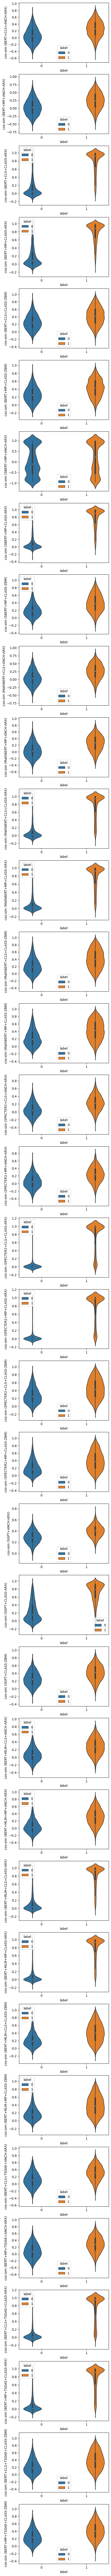

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", scale="count", scale_hue=True, ax=axs[i])

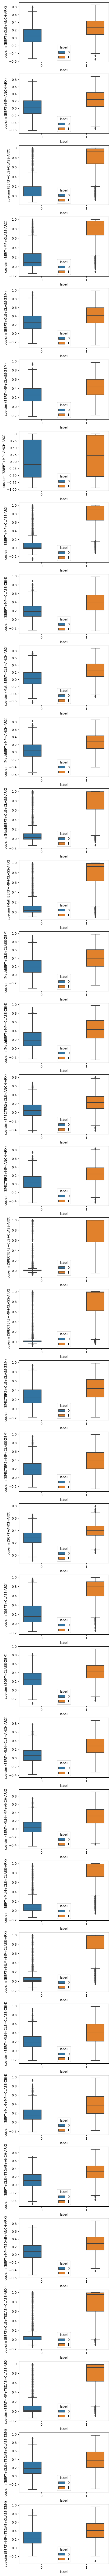

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i])

In [15]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,label,categories_a,text_a,categories_b,text_b,cos-sim (BERT+CLS+ANCH-ARX),cos-sim (BERT+MP+ANCH-ARX),cos-sim (BERT+CLS+CLASS-ARX),cos-sim (BERT+MP+CLASS-ARX),cos-sim (BERT+CLS+CLASS-ZBM),cos-sim (BERT+MP+CLASS-ZBM),cos-sim (SBERT+MP+ANCH-ARX),cos-sim (SBERT+MP+CLASS-ARX),cos-sim (SBERT+MP+CLASS-ZBM),cos-sim (MathBERT+CLS+ANCH-ARX),cos-sim (MathBERT+MP+ANCH-ARX),cos-sim (MathBERT+CLS+CLASS-ARX),cos-sim (MathBERT+MP+CLASS-ARX),cos-sim (MathBERT+CLS+CLASS-ZBM),cos-sim (MathBERT+MP+CLASS-ZBM),...,cos-sim (SPECTER2+MP+ANCH-ARX),cos-sim (SPECTER2+CLS+CLASS-ARX),cos-sim (SPECTER2+MP+CLASS-ARX),cos-sim (SPECTER2+CLS+CLASS-ZBM),cos-sim (SPECTER2+MP+CLASS-ZBM),cos-sim (SGPT+ANCH-ARX),cos-sim (SGPT+CLASS-ARX),cos-sim (SGPT+CLASS-ZBM),cos-sim (BERT+MLM+CLS+ANCH-ARX),cos-sim (BERT+MLM+MP+ANCH-ARX),cos-sim (BERT+MLM+CLS+CLASS-ARX),cos-sim (BERT+MLM+MP+CLASS-ARX),cos-sim (BERT+MLM+CLS+CLASS-ZBM),cos-sim (BERT+MLM+MP+CLASS-ZBM),cos-sim (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (BERT+MP+TSDAE+ANCH-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (BERT+MP+TSDAE+CLASS-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (BERT+MP+TSDAE+CLASS-ZBM)
14175,1,"('math.CO',)",On Weak Chromatic Polynomials of Mixed Graphs....,"('math.CO',)",Projective Equivalences of k-neighbourly Polyt...,0.509056,0.605747,0.995220,0.985169,0.157457,0.317608,0.852958,0.964971,0.255816,0.252524,0.171674,0.974188,0.982144,0.420033,0.526238,...,0.344977,0.998871,0.998525,0.225024,0.132975,0.518043,0.739857,0.505732,0.292086,0.248980,0.994112,0.984355,0.191435,0.237264,0.396700,0.384578,0.995092,0.987498,0.078823,0.080655
29240,1,"('math.GR',)",Galois Theory - a first course. These notes ar...,"('math.GR',)",On p-stability in groups and fusion systems. T...,0.204409,0.228975,0.852779,0.378374,0.217245,0.427145,0.943942,0.320470,0.497718,0.249425,0.297179,0.797666,0.632697,0.271390,0.626453,...,0.282888,0.914754,0.896009,0.549021,0.462668,0.229484,0.294742,0.447706,0.268623,0.143440,0.329151,0.436323,0.338398,0.237079,0.410792,0.233215,0.806124,0.615465,0.509049,0.537919
31864,1,"('math.KT',)",Controlled $K$-theory and $K$-Homology. An ope...,"('math.KT',)",Cyclic homology of braided Hopf crossed produc...,-0.229320,-0.380958,0.714436,0.796423,0.715699,0.606930,-0.899522,0.763968,0.773454,0.163479,0.175321,0.785818,0.390522,0.568384,0.792696,...,0.137167,0.956458,0.976762,0.628264,0.757547,0.358595,0.811548,0.756720,-0.002239,0.020442,0.889192,0.829458,0.759876,0.735416,-0.055858,-0.168315,0.939130,0.750853,0.554171,0.551794
48373,1,"('math.RA',)",Simple subalgebras of simple special Jordan al...,"('math.RA',)",Normalization of Quaternionic Polynomials. Qua...,0.313373,0.401774,0.928767,0.902125,0.179822,0.460182,0.883705,0.946613,0.712207,0.562750,0.541988,0.951051,0.860641,0.597777,0.080318,...,0.382973,0.034568,0.239677,0.321844,0.492562,0.418515,0.514679,0.565926,0.602277,0.496458,0.896799,0.671971,0.326469,0.417077,0.285653,0.355816,0.799380,0.566764,0.406112,0.058972
11994,1,"('math.CA',)",On some Hadamard-Type Inequalities for Co-ordi...,"('math.CA',)",Non-differentiable solutions for local fractio...,-0.097926,0.087061,0.706086,0.610826,-0.039752,-0.036073,-0.640311,0.671631,-0.004845,0.167725,0.079717,0.680349,0.558550,0.081672,0.103875,...,0.219347,0.958703,0.654307,-0.023367,-0.032169,0.289008,0.446788,0.269823,0.151215,-0.018717,0.880896,0.377943,0.058243,0.026946,-0.054838,-0.023930,0.825534,0.477520,-0.024496,0.079093
48427,1,"('math.RA',)",Basic superranks for varieties of algebras. We...,"('math.RA',)",A note on solvable maximal subgroups in subnor...,0.536661,0.498345,0.978350,0.964560,0.319561,0.514093,0.997497,0.948114,0.271067,0.112833,0.396088,0.859897,0.969530,0.473850,0.475978,...,0.047806,0.995020,0.984015,0.268692,0.475304,0.389549,0.844391,0.449747,0.236011,0.165073,0.952567,0.921707,0.397415,0.384609,0.476377,0.459020,0.949678,0.973217,0.501330,0.540649
22315,0,"('math.DG',)",Tensor tomography on Cartan-Hadamard manifolds...,"('math.OC',)",A new conical interna